In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
import tensorflow.keras.backend as K
import os
import numpy as np
from tqdm import tqdm_notebook
from scipy.ndimage import zoom
%matplotlib inline

In [2]:
def clipped_zoom(img, zoom_factor, **kwargs):
    #https://stackoverflow.com/questions/37119071/scipy-rotate-and-zoom-an-image-without-changing-its-dimensions
    h, w = img.shape[:2]
    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor, ) * 2 + (1, ) * (img.ndim - 2)
    # Zooming out
    if zoom_factor < 1:
        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        # Zero-padding
        out = np.zeros_like(img)
        out[top:top + zh, left:left + zw] = zoom(img, zoom_tuple, **kwargs)
    # Zooming in
    elif zoom_factor > 1:
        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = zoom(img[top:top + zh, left:left + zw], zoom_tuple, **kwargs)
        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top + h, trim_left:trim_left + w]
    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

In [3]:
img_size = 255
epochs = 20
batch_size = 5
channel = 3
if channel==1:
    gray_scale = True
else:
    gray_scale = False

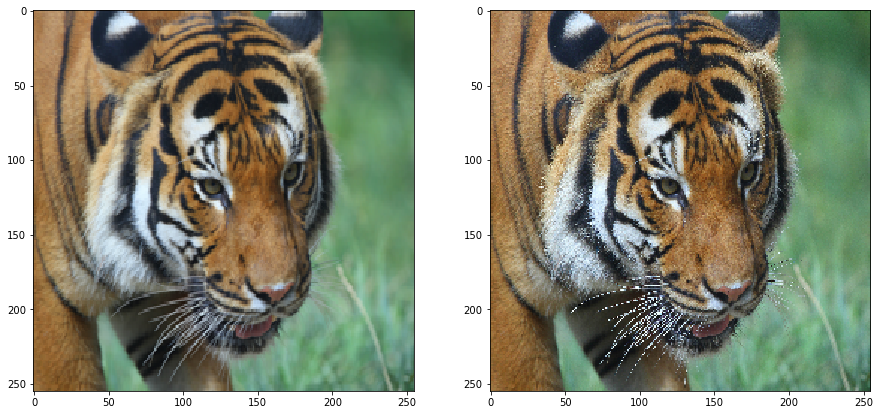

In [4]:
x = load_img("./X_train/DIV2K_train_LR_x8/0010x8.png",
             target_size=(img_size, img_size), grayscale=gray_scale)
x = np.array(x)/255
x = x.reshape(1, img_size, img_size, channel)

y = load_img("./y_train/DIV2K_train_HR/0010.png",
             target_size=(img_size, img_size), grayscale=gray_scale)
y = np.array(y)/255
y = y.reshape(1, img_size, img_size, channel)

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(x.reshape(img_size, img_size, channel))
ax[1].imshow(y.reshape(img_size, img_size, channel))
plt.show()

In [5]:
K.clear_session()
model = Sequential()
model.add(Input(shape=(img_size, img_size, channel)))
model.add(Conv2D(filters=64, kernel_size=9, activation="relu", padding="same"))
model.add(Conv2D(filters=32, kernel_size=1, activation="relu", padding="same"))
model.add(Conv2D(filters=channel, kernel_size=5, activation=None, padding="same"))

adam = Adam(0.003)
model.compile(loss="mean_squared_error", optimizer=adam)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 255, 255, 64)      15616     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 255, 255, 32)      2080      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 255, 255, 3)       2403      
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


In [6]:
X_train = []
y_train = []
progress = tqdm_notebook(range(epochs))
for e in progress:
    loss = 0
    i = 0
    for root, dirs, files in os.walk("./y_train/"):
        for file in list(files):
            x_path = os.path.join("./X_train/DIV2K_train_LR_x8/",
                                  file[:-4] + "x8.png")
            y_path = os.path.join(root, file)
            X = load_img(x_path, target_size=(img_size, img_size, channel), grayscale=gray_scale)
            y = load_img(y_path, target_size=(img_size, img_size, channel), grayscale=gray_scale)
            X_train.append(np.array(X)/255)
            y_train.append(np.array(y)/255)
            if len(X_train) == batch_size:
                X_train = np.array(X_train).reshape(-1,img_size,img_size,channel)
                y_train = np.array(y_train).reshape(-1,img_size,img_size,channel)
                hist = model.fit(X_train,
                                 y_train,
                                 verbose=0,
                                 batch_size=batch_size)
                X_train = []
                y_train = []
                progress.set_description("iteration: {}/{}".format(str(i), len(files)/batch_size))
                i+=1
                loss += hist.history["loss"][0]
    print("loss: {}".format(loss / len(files)*batch_size))

loss: 0.019771951623260977
loss: 0.008143991693214048
loss: 0.0072424863537889905
loss: 0.007008109980961307
loss: 0.006776559658464976
loss: 0.00688539232360199
loss: 0.006524076712958049
loss: 0.00714235997875221
loss: 0.006516745056433138
loss: 0.006631281369482166
loss: 0.006370484041690361
loss: 0.006779939317493699
loss: 0.0064934424182865776
loss: 0.006360427559411619
loss: 0.006259832157229539
loss: 0.007670260059239809
loss: 0.009107691010285635
loss: 0.006750117892806884
loss: 0.006594025854428765
loss: 0.0066833829027018515



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


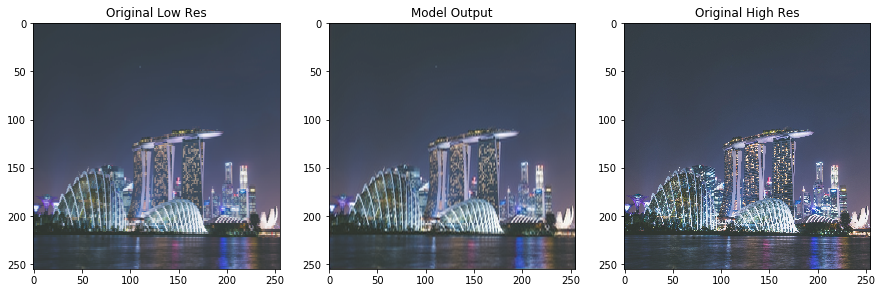

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


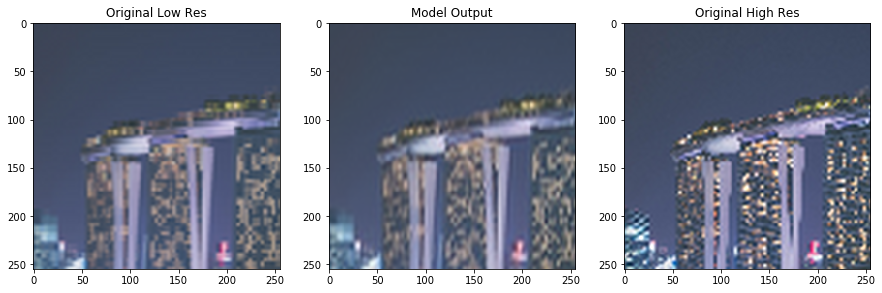

In [14]:
x = load_img("./X_test/DIV2K_valid_LR_x8/0814x8.png",
             target_size=(img_size, img_size, channel), grayscale=gray_scale)
x = np.array(x)/255
x = x.reshape(1, img_size, img_size, channel)

y = load_img("./y_test/DIV2K_valid_HR/0814.png",
             target_size=(img_size, img_size, channel), grayscale=gray_scale)
y = np.array(y)/255
y = y.reshape(1, img_size, img_size, channel)

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(x.reshape(img_size, img_size, channel))
ax[1].imshow(model.predict(x).reshape(img_size, img_size, channel))
ax[2].imshow(y.reshape(img_size, img_size, channel))
ax[0].set_title("Original Low Res")
ax[1].set_title("Model Output")
ax[2].set_title("Original High Res")
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(clipped_zoom(x.reshape(img_size, img_size, channel), 3))
ax[1].imshow(clipped_zoom(model.predict(x).reshape(img_size, img_size, channel), 3))
ax[2].imshow(clipped_zoom(y.reshape(img_size, img_size, channel), 3))
ax[0].set_title("Original Low Res")
ax[1].set_title("Model Output")
ax[2].set_title("Original High Res")
plt.show()